In [1]:
%load_ext autoreload
%autoreload 2

In [207]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import cosmology
from astropy.modeling import fitting

import SAGA  
from SAGA import ObjectCuts as C

from SAGAbg.utils import calc_kcor
from SAGAbg import SAGA_get_spectra, line_fitting
import namer

import sys
sys.path.append('../scripts/')
import find_oiii4363

In [24]:
cosmo = cosmology.FlatLambdaCDM (70., 0.3)
dropbox_directory = '/Users/kadofong/Dropbox/SAGA/'
line_wavelengths = line_fitting.line_wavelengths
windowwidth = 100.
linewidth = 14.

In [5]:
clean = find_oiii4363.build_saga_catalog ()

SAGA `shared_dir` set to /Users/kadofong/DropBox/SAGA/
SAGA `local_dir`  set to ../local_data/


/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:347: RuntimeWarning: divide by zero encountered in true_divide
  self._T_hypergeometric(s / (z2 + 1.0)))
/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:369: RuntimeWarning: invalid value encountered in multiply
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)


In [348]:
first_objects = clean[(clean['selection']==3)&(clean['ZQUALITY']>=3)&((clean['TELNAME']=='AAT')|(clean['TELNAME']=='MMT'))]
all_the_good_spectra = clean[(clean['ZQUALITY']>=3)&((clean['TELNAME']=='AAT')|(clean['TELNAME']=='MMT'))]
low_mass = all_the_good_spectra[all_the_good_spectra['cm_logmstar']<9.]

In [349]:
len(low_mass)

4601

In [357]:
low_mass[low_mass['EW_Halpha']>0.][['wordid','OBJID','EW_Halpha']]

wordid,OBJID,EW_Halpha
str39,int64,float32
career_commemorates,904501610000001442,38.1368
gaudiness_eerily,904474680000001083,7.0929
deduces_precondition,900316320000001800,2.3719
veil_logicians,900335040000000543,16.7041
mainspring_exogenous,900335050000000168,2.3132
recency_waders,902830190000003292,40.8283
caracals_recalling,902815900000001064,48.5156
linearly_promenade,902830170000003562,2.464
reek_splints,904311870000002299,213.13


In [364]:
line_fluxes, model_fit, model_noabs = linesearch.singleton ( clean.loc['career_commemorates'], '/Users/kadofong/Dropbox/SAGA' )

/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/modeling/functional_models.py:180: RuntimeWarning: divide by zero encountered in true_divide
  return amplitude * np.exp(- 0.5 * (x - mean) ** 2 / stddev ** 2)


[u_flux] 9 sec elapsed; 0.09 avg. laptime


In [365]:
line_fitting.compute_lineflux ( model_fit.amplitude_0, model_fit.stddev_0 ) / model_fit.amplitude_1

37.75728456807218

In [395]:
import glob 
computed = np.array(glob.glob('../local_data/line_fits/*/*lineparamsNOABSORPTION.dat'))
names = np.array([ x.split('/')[-2] for x in computed ] )

has_sagaHA = clean['EW_Halpha']>0.

In [385]:
hits = np.in1d ( names, clean[has_sagaHA]['wordid'] )

In [405]:
haew_arr = np.zeros([hits.sum(), 2])
for model_index, model_file in enumerate(computed[hits]):
    model = np.genfromtxt(model_file)
    fluxes = np.genfromtxt(model_file.replace('lineparamsNOABSORPTION', 'fluxes'))
    haew_arr[model_index,0] = fluxes[0,3] / model[3]
    haew_arr[model_index,1] = fluxes[2,3] / model[3]


Text(0, 0.5, '(this - catalog)/catalog')

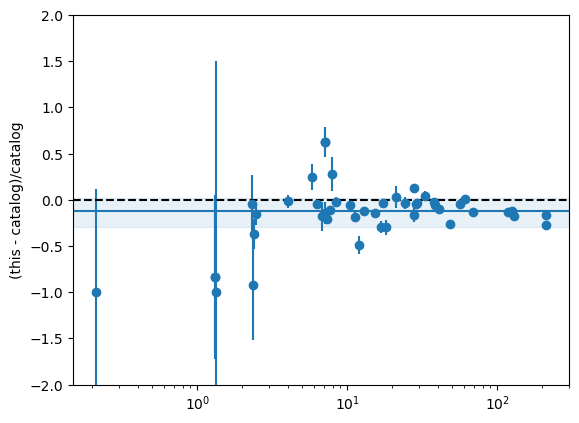

In [428]:
haew_gt = clean.loc[names[hits]]['EW_Halpha']
plt.errorbar ( haew_gt, (haew_arr[:,0] - haew_gt)/haew_gt, fmt='o', yerr=3.*haew_arr[:,1]/haew_gt )
plt.axhline(np.median((haew_arr[:,0] - haew_gt)/haew_gt), color='C0')
plt.axhspan(*np.quantile((haew_arr[:,0] - haew_gt)/haew_gt, [0.16,.84]), color='C0', alpha=0.1)
plt.axhline(0., color='k', ls='--')
plt.ylim(-2,2)
plt.xscale('log')
plt.ylabel('(this - catalog)/catalog')

[u_flux] 9 sec elapsed; 0.09 avg. laptime


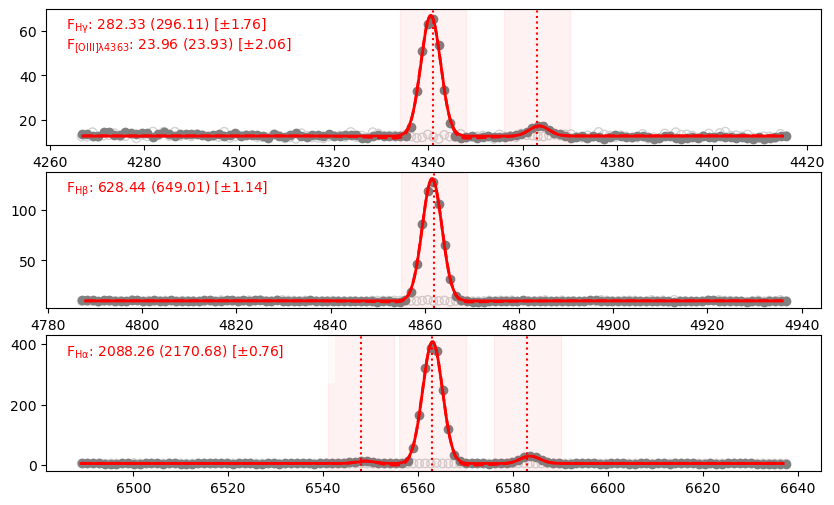

In [345]:
out = linesearch.singleton ( clean.loc['upkeep_transposed'], '/Users/kadofong/Dropbox/SAGA' )

In [346]:
clean.loc['upkeep_transposed']

OBJID,RA,DEC,REMOVE,is_galaxy,morphology_info,radius,radius_err,ba,phi,sma,REF_CAT,SGA_ID,EBV,SERSIC,u_mag,g_mag,r_mag,i_mag,z_mag,u_err,g_err,r_err,i_err,z_err,w1_mag,w2_mag,w3_mag,w4_mag,w1_err,w2_err,w3_err,w4_err,g_fibermag,r_fibermag,z_fibermag,g_fibertotmag,r_fibertotmag,z_fibertotmag,survey,OBJID_decals,REMOVE_decals,HOSTID,HOST_PGC,HOST_NSAID,HOST_NSA1ID,HOST_SAGA_NAME,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_ZCOSMO,HOST_MK,HOST_COMMON_NAME,RHOST_ARCM,RHOST_KPC,SPEC_Z,SPEC_Z_ERR,ZQUALITY,SPECOBJID,MASKNAME,TELNAME,HELIO_CORR,OBJ_NSAID,SPEC_REPEAT,SPEC_REPEAT_ALL,RA_spec,DEC_spec,OBJ_PGC,EW_Halpha,EW_Halpha_err,RA_nuv,DEC_nuv,nuv_mag,nuv_err,RA_fuv,DEC_fuv,fuv_mag,fuv_err,nuv_snr,nuv_sfr,nuv_sfr_flag,SATS,sb_r,sb_r_err,z_cosmo,Mr,log_sm,spec_phot_sep,quenched,ug,ug_err,gr,gr_err,ri,ri_err,iz,iz_err,rz,rz_err,human_selected,p_sat_model_p2,p_sat_model_p3,p_sat_corrected,wordid,selection,Mg,Kg,Kr,Mz,Kz,cm_logmstar
int64,float64,float64,int32,bool,int32,float32,float32,float32,float32,float32,str2,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str6,int64,int32,str48,int32,int32,int32,str48,float32,float32,float32,float32,float32,float32,str48,float32,float32,float32,float32,int32,str48,str48,str6,bool,int32,str48,str48,float64,float64,int64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,int32,int32,float32,float32,float32,float64,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,str39,int64,float64,float32,float32,float64,float32,float64
923591040000004951,348.69649083094004,4.639668155260525,0,True,800,8.810076,0.0032390736,0.58713675,1.949569,34.493027,,-1,0.06813268,2.091561,99.0,15.232645,14.991543,99.0,14.901281,99.0,0.0004933204,0.00062030106,99.0,0.0010671391,15.809451,16.372442,15.590625,13.93242,0.00068367674,0.0022340934,0.03496005,0.041587725,19.348507,19.107405,19.017143,19.26093,19.067722,18.985384,decals,923591040000004951,0,nsa150887,70795,150887,637128,Catch22,348.68277,4.533989,38.08904,2680.0,0.008831568,-24.567543,NGC7541,6.3936877,70.8398,0.009547562,5e-06,4,130,spHect-2015.0918_1.zlog,MMT,True,-1,MMT+ALFALF,MMT+ALFALF,348.696641925,4.639955044,-1,327.0883,0.4996,348.69649083,4.63966816,16.777,0.023,nan,nan,nan,nan,46.6,-0.7138,1,1,21.711891,0.0010110106,0.008831568,-18.094565507692494,8.688113,1.166451,0,83.76736,99.0,0.24110222,0.00079255184,-84.00845,99.0,84.09872,99.0,0.09026146,0.0012343255,0,0.44317707,0.20453878,1.0,upkeep_transposed,3,-17.833997469132044,-0.007405606,0.012060214,-18.175660101433493,0.0028933482,8.94753625127756


In [333]:
np.random.uniform ( 0., 1. )

0.9278514703071106

In [330]:
(len(first_objects)*100*u.kilobyte).to(u.gigabyte)

<Quantity 0.7322 Gbyte>

SAGA `shared_dir` set to /Users/kadofong/DropBox/SAGA/
SAGA `local_dir`  set to ../local_data/


/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:347: RuntimeWarning: divide by zero encountered in true_divide
  self._T_hypergeometric(s / (z2 + 1.0)))
/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:369: RuntimeWarning: invalid value encountered in multiply
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)
/Users/kadofong/opt/miniconda3/envs/vanilla/lib/python3.10/site-packages/astropy/modeling/functional_models.py:180: RuntimeWarning: divide by zero encountered in true_divide
  return amplitude * np.exp(- 0.5 * (x - mean) ** 2 / stddev ** 2)


[u_flux] 9 sec elapsed; 0.09 avg. laptime
[u_flux] 9 sec elapsed; 0.09 avg. laptime
[u_flux] 9 sec elapsed; 0.09 avg. laptime


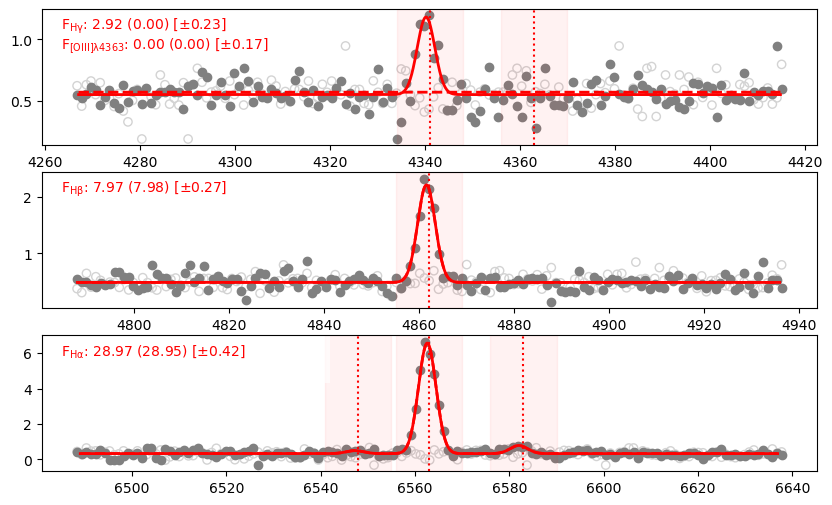

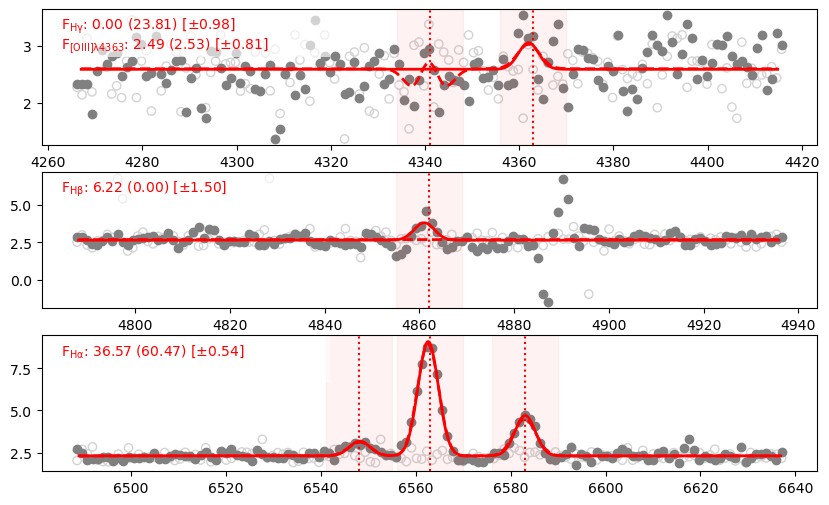

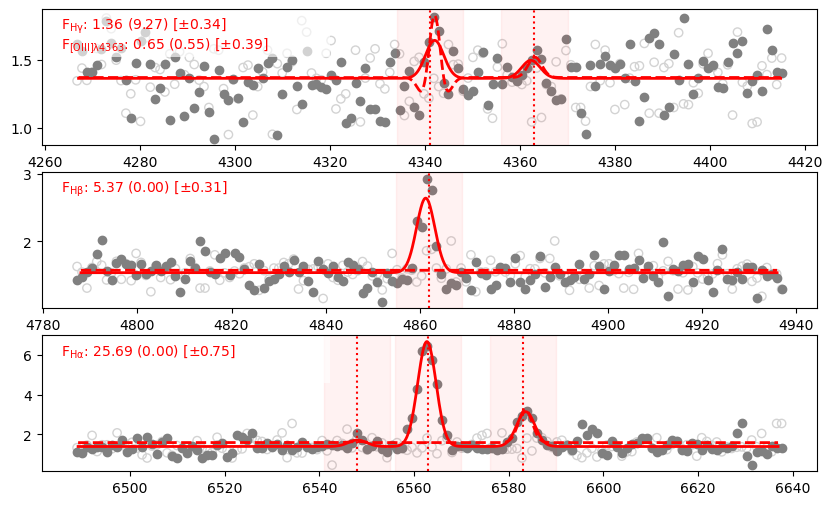

In [325]:
linesearch.main ( '/Users/kadofong/Dropbox/SAGA/', '/Users/kadofong/Downloads/')

[u_flux] 9 sec elapsed; 0.09 avg. laptime


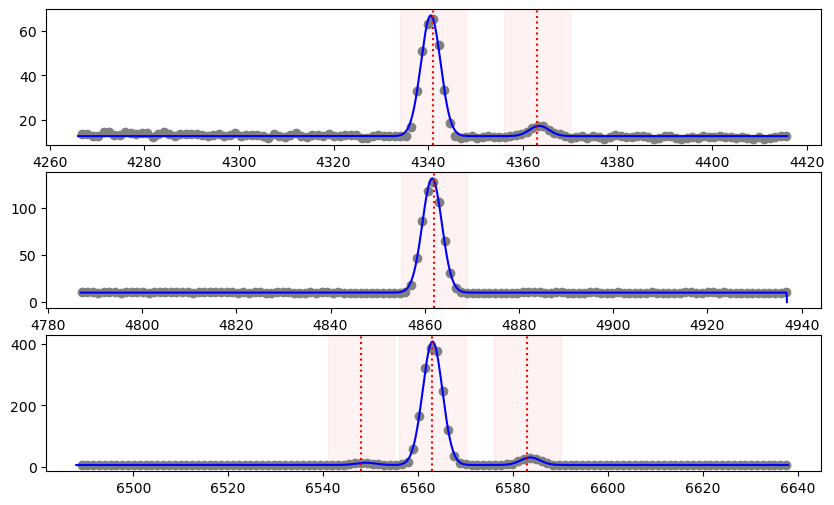

In [229]:
line_fluxes, model_fit = linesearch.singleton ( clean.loc['upkeep_transposed'], '/Users/kadofong/Dropbox/SAGA/' )

In [231]:
np.savetxt(model_fit.parameters

(36,)

In [ ]:
obj = clean.loc['upkeep_transposed'] #'upkeep_transposed'appreciations_tresses


In [202]:
flux, wave, ivar, _ = SAGA_get_spectra.saga_get_spectrum(obj, dropbox_directory)
restwave = wave / (1. + obj['SPEC_Z'] )

In [203]:
outside_windows, outside_lines = line_fitting.define_lineblocs ( restwave )
this_model = line_fitting.build_linemodel ( restwave, flux )
fitter = fitting.LevMarLSQFitter ()

In [204]:
model_fit = fitter ( this_model, restwave[~outside_windows], flux[~outside_windows] )

In [205]:
halpha_flux = line_fitting.compute_lineflux ( model_fit.amplitude_0, model_fit.stddev_0 )
oiii_flux = line_fitting.compute_lineflux ( model_fit.amplitude_8, model_fit.stddev_0 )
hbeta_flux = line_fitting.compute_lineflux ( model_fit.amplitude_6, model_fit.stddev_0 )
hgamma_flux = line_fitting.compute_lineflux ( model_fit.amplitude_10, model_fit.stddev_0 )
flux_arr = np.array([hgamma_flux, oiii_flux, hbeta_flux, halpha_flux])

In [216]:
halpha_bloc = line_fitting.get_linewindow ( restwave, line_wavelengths['Halpha'], windowwidth )
hbeta_bloc = line_fitting.get_linewindow ( restwave, line_wavelengths['Hbeta'], windowwidth )
hgamma_bloc = line_fitting.get_linewindow ( restwave, line_wavelengths['Hgamma'], windowwidth )

npull = 100
u_flux_arr = np.zeros([npull, 4])
start = time.time ()
for pull in range(npull):
    # \\ repull from non-line local areas of the spectrum
    frandom = np.zeros_like(restwave)
    frandom[halpha_bloc] = np.random.choice(flux[halpha_bloc&outside_lines], size=halpha_bloc.sum(), replace=True)
    frandom[hbeta_bloc] = np.random.choice(flux[hbeta_bloc&outside_lines], size=hbeta_bloc.sum(), replace=True)
    frandom[hgamma_bloc] = np.random.choice(flux[hgamma_bloc&outside_lines], size=hgamma_bloc.sum(), replace=True)
    
    random_fit = fitter ( this_model, restwave[~outside_windows], frandom[~outside_windows] )
    u_flux_arr[pull,3] = line_fitting.compute_lineflux ( random_fit.amplitude_0, random_fit.stddev_0 )
    u_flux_arr[pull,1] = line_fitting.compute_lineflux  (  random_fit.amplitude_8, random_fit.stddev_0 )
    u_flux_arr[pull,2] = line_fitting.compute_lineflux  ( random_fit.amplitude_6, random_fit.stddev_0 )
    u_flux_arr[pull,0] = line_fitting.compute_lineflux ( random_fit.amplitude_10,random_fit.stddev_0 )    
elapsed = time.time() - start
print(f'{elapsed:.0f} sec elapsed; {elapsed/npull:.0f} avg. laptime')

9 sec elapsed; 0 avg. laptime


In [222]:
line_fluxes = np.array([flux_arr,u_flux_arr.std(axis=0)])

In [224]:
line_fluxes[0]/line_fluxes[1]

array([ 118.94282337,    9.02176766,  317.80379815, 1587.06040886])

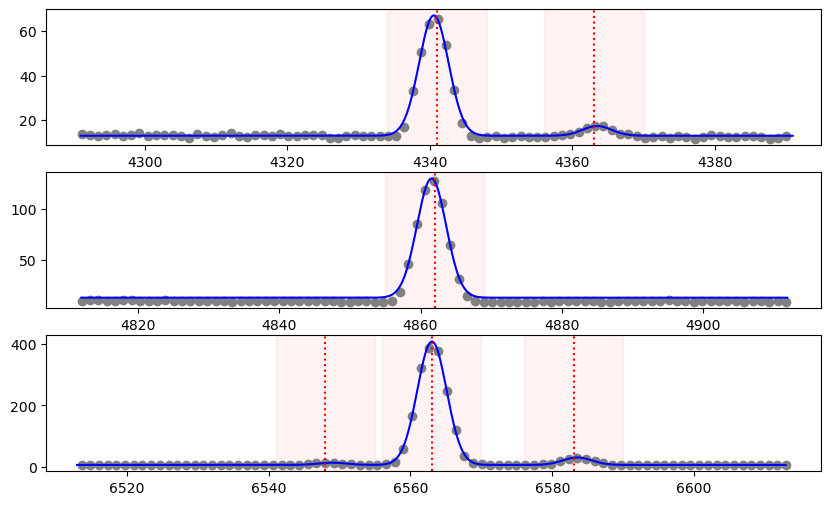

In [218]:
fig, axarr = plt.subplots(3,1,figsize=(10,6))

for ax_index,key in enumerate(['Hgamma','Hbeta','Halpha']):
    line_wl=line_wavelengths[key]
    ax = axarr[ax_index]
    xs = np.arange(line_wl - windowwidth/2., line_wl + windowwidth/2.,.1)
    in_transmission = abs(restwave-line_wl) <= (windowwidth/2.)
    ax.plot ( restwave[in_transmission], flux[in_transmission], 'o',color='grey')
    xlim = ax.get_xlim()
    ax.plot ( xs, model_fit(xs), color='b')

    for wv in line_wavelengths.values():
        ax.axvline(wv, color='r', ls=':')
        ax.axvspan(wv-linewidth/2.,wv+linewidth/2., color='r',alpha=0.05)
    ax.set_xlim(xlim)